# **Práctica 1: Sensado y análisis de audio**

### Ciencia de Datos para Sensores Inteligentes/Tópicos Selectos en Sistemas Interactivos

*Estudiante: Cielo Aholiva Higuera Gutiérrez*

El objetivo de este notebook es implementar un sistema de registro de asistencia basado en el reconocimiento de audio, ofreciendo una alternativa moderna y eficiente al uso tradicional de listas en papel o códigos QR.

### **Dataset**

El dataset fue generado mediante la grabación de audio de personas reales pronunciando frases relacionadas con el registro de asistencia, simulando escenarios de ingreso.

El formato para los nombres de los archivos es el siguiente: PERSONA-METODO_NUM.
* PERSONA es el nombre de ustedes para identificar los archivos individuales;
* METODO modalidad de captura, ver datos de la práctica.
* NUM es un número consecutivo para los audios recolectados.

*Importar librerias*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pydub --quiet
!apt-get install ffmpeg --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [54]:
# Data
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
import joblib

# Audio
from pydub import AudioSegment
import IPython.display as ipd
from IPython.display import Audio, display, Markdown
from pydub import AudioSegment
from scipy.signal import butter, lfilter
import librosa
import wave
import soundfile as sf
import librosa.display

# Modelos

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
# Dirección de la carpeta con el dataset.
base_path = "/content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO"

### **Procesamiento de datos de audio**

In [ ]:
# Extensiones de audio que queremos convertir
audio_extensions = ('.mp3', '.m4a', '.opus', '.ogg', '.wav')

# Recorrer todas las subcarpetas y procesar los archivos
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(audio_extensions):
            audio_path = os.path.join(root, file)  # Ruta completa del archivo original
            wav_path = os.path.join(root, os.path.splitext(file)[0] + '.wav')  # Ruta de salida en formato WAV

            # Convertir el archivo a WAV solo si no existe ya el archivo WAV
            if not os.path.exists(wav_path):
                try:
                    audio = AudioSegment.from_file(audio_path)
                    audio.export(wav_path, format="wav")
                    print(f"Convertido: {audio_path} -> {wav_path}")
                except Exception as e:
                    print(f"Error al convertir {audio_path}: {e}")

Convertido: /content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO/Ignacio-Campos/Practica-01_Audio/Ignacio-03-02.mp3 -> /content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO/Ignacio-Campos/Practica-01_Audio/Ignacio-03-02.wav
Convertido: /content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO/Ignacio-Campos/Practica-01_Audio/Ignacio-03-04.mp3 -> /content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO/Ignacio-Campos/Practica-01_Audio/Ignacio-03-04.wav
Convertido: /content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO/Ignacio-Campos/Practica-01_Audio/Ignacio-03-03.mp3 -> /content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO/Ignacio-Campos/Practica-01_Audio/Ignacio-03-03.wav
Convertido: /content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO/Ignacio-Campos/Practica-01_Audio/Ignacio-03-05.mp3 -> /content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO/Ignacio-Campos/Practica-01_Audio/Ignacio-03-05.wav
Convertido: /content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO/Luis-Garcia/Practica-01_A

In [ ]:
# Null Class
null_path = "/content/drive/MyDrive/Nula"
audio_extensions = ('.mp4', '.m4a')

# Recorrer todas las subcarpetas y procesar los archivos
for root, dirs, files in os.walk(null_path):
    for file in files:
        if file.endswith(audio_extensions):
            null_path = os.path.join(root, file)  # Ruta completa del archivo original
            wav_path = os.path.join(root, os.path.splitext(file)[0] + '.wav')  # Ruta de salida en formato WAV

            # Convertir el archivo a WAV solo si no existe ya el archivo WAV
            if not os.path.exists(wav_path):
                try:
                    audio = AudioSegment.from_file(null_path)
                    audio.export(wav_path, format="wav")
                    print(f"Convertido: {null_path} -> {wav_path}")
                except Exception as e:
                    print(f"Error al convertir {null_path}: {e}")

In [12]:
audio_data = []

# Recorrer todas las subcarpetas y encontrar archivos .wav
for root, _, files in os.walk(base_path):
    for file in files:
        if file.endswith('.wav'):
            try:
                # Obtener el nombre del archivo sin la ruta completa
                file_path = os.path.join(root, file)
                file_name = os.path.splitext(file)[0]

                # Extraer información
                if '-' in file_name and '_' in file_name:
                    name, method_num = file_name.rsplit('-', 1)
                    method, num = method_num.rsplit('_', 1)

                    num = int(num)

                    # Guardar datos estructurados
                    audio_data.append({
                        "Archivo": file,
                        "Ruta": file_path,
                        "Persona": name,
                        "Método": method,
                        "Número": num
                    })
                else:
                    print(f"Archivo {file} no sigue el formato esperado.")

            except ValueError as e:
                print(f"Error procesando {file}: {e}")

# Crear un DataFrame con los datos recolectados
audio_df = pd.DataFrame(audio_data)
print(audio_df.head())

                   Archivo                                               Ruta  \
0         Ariana-02_05.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   
1         Ariana-01_01.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   
2  AndresCalzada-01_05.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   
3         Ariana-02_02.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   
4         Ariana-03_01.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   

         Persona Método  Número  
0         Ariana     02       5  
1         Ariana     01       1  
2  AndresCalzada     01       5  
3         Ariana     02       2  
4         Ariana     03       1  


In [13]:
null_path = "/content/drive/MyDrive/Nula"
audio_data = []
# Función para extraer la información del archivo
def process_audio_file(file, root):
    try:
        # Obtener el nombre del archivo sin la ruta completa
        file_path = os.path.join(root, file)
        file_name = os.path.splitext(file)[0]

        # Extraer información del nombre de archivo
        if '-' in file_name and '_' in file_name:
            name, method_num = file_name.rsplit('-', 1)
            method, num = method_num.rsplit('_', 1)

            num = int(num)

            # Guardar datos estructurados
            audio_data.append({
                "Archivo": file,
                "Ruta": file_path,
                "Persona": name,
                "Método": method,
                "Número": num
            })
        else:
            print(f"Archivo {file} no sigue el formato esperado.")

    except ValueError as e:
        print(f"Error procesando {file}: {e}")

# Recorrer todas las subcarpetas y encontrar archivos .wav
# Para los archivos del path principal (base_path)
for root, _, files in os.walk(base_path):
    for file in files:
        if file.endswith('.wav'):
            process_audio_file(file, root)

# Incluir archivos de 'null_path'
for root, _, files in os.walk(null_path):
    for file in files:
        if file.endswith('.wav'):
            process_audio_file(file, root)

# Crear un DataFrame con los datos recolectados
audio_df = pd.DataFrame(audio_data)
print(audio_df.head())

                   Archivo                                               Ruta  \
0         Ariana-02_05.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   
1         Ariana-01_01.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   
2  AndresCalzada-01_05.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   
3         Ariana-02_02.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   
4         Ariana-03_01.wav  /content/drive/MyDrive/CDSI/Notebooks/Practica...   

         Persona Método  Número  
0         Ariana     02       5  
1         Ariana     01       1  
2  AndresCalzada     01       5  
3         Ariana     02       2  
4         Ariana     03       1  


In [14]:
# Ruta para guardar en Google Drive
csv_path = "/content/drive/MyDrive/CDSI/Notebooks/audio_df.csv"

# Guardar el DataFrame en Drive
audio_df.to_csv(csv_path, index=False)
print(f"Archivo guardado en: {csv_path}")

Archivo guardado en: /content/drive/MyDrive/CDSI/Notebooks/audio_df.csv


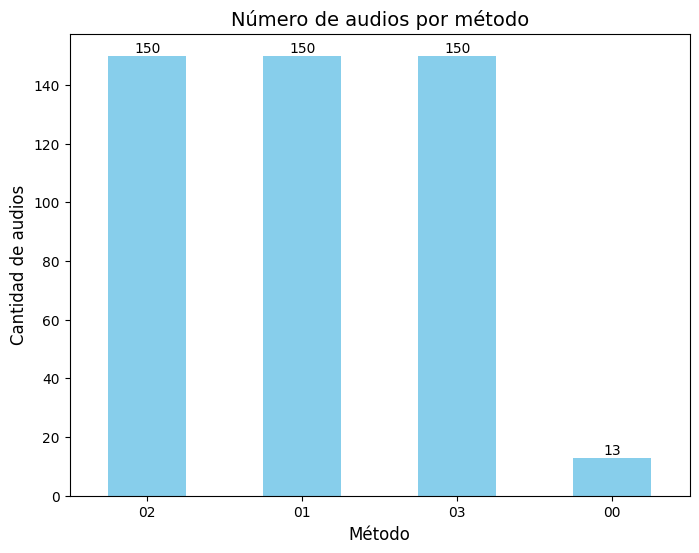

In [ ]:
# Contar métodos en el DataFrame
method_counts = audio_df['Método'].value_counts()

# Gráfico de barras
plt.figure(figsize=(8, 6))
method_counts.plot(kind='bar', color='skyblue')
plt.title('Número de audios por método', fontsize=14)
plt.xlabel('Método', fontsize=12)
plt.ylabel('Cantidad de audios', fontsize=12)
plt.xticks(rotation=0)

# Mostrar valores sobre las barras
for i, v in enumerate(method_counts):
    plt.text(i, v + 1, str(v), ha='center', fontsize=10)

plt.show()

### **Reproducción de audio**

In [ ]:
method_01, sr = librosa.load('/content/drive/MyDrive/Practica-01_Audio/Maria-01_01.wav')
print(f"Frecuencia de la muestra (Método 1): {sr} Hz")
print(f"Duración del audio de método 1: {librosa.get_duration(y=method_01, sr=sr)} segundos")

method_02, sr = librosa.load('/content/drive/MyDrive/Practica-01_Audio/Vanessa-02_01.wav')
print(f"Frecuencia de la muestra (Método 2): {sr} Hz")
print(f"Duración del audio de método 2: {librosa.get_duration(y=method_02, sr=sr)} segundos")

method_03, sr = librosa.load('/content/drive/MyDrive/Practica-01_Audio/Sergio-03_01.wav')
print(f"Frecuencia de la muestra (Método 3): {sr} Hz")
print(f"Duración del audio de método 3: {librosa.get_duration(y=method_03, sr=sr)} segundos")


Frecuencia de la muestra (Método 1): 22050 Hz
Duración del audio de método 1: 2.391655328798186 segundos
Frecuencia de la muestra (Método 2): 22050 Hz
Duración del audio de método 2: 2.4380952380952383 segundos
Frecuencia de la muestra (Método 3): 22050 Hz
Duración del audio de método 3: 3.622312925170068 segundos


In [ ]:
Audio(method_01, rate=sr)

In [ ]:
Audio(method_02, rate=sr)

In [ ]:
Audio(method_03, rate=sr)

Extracción de características

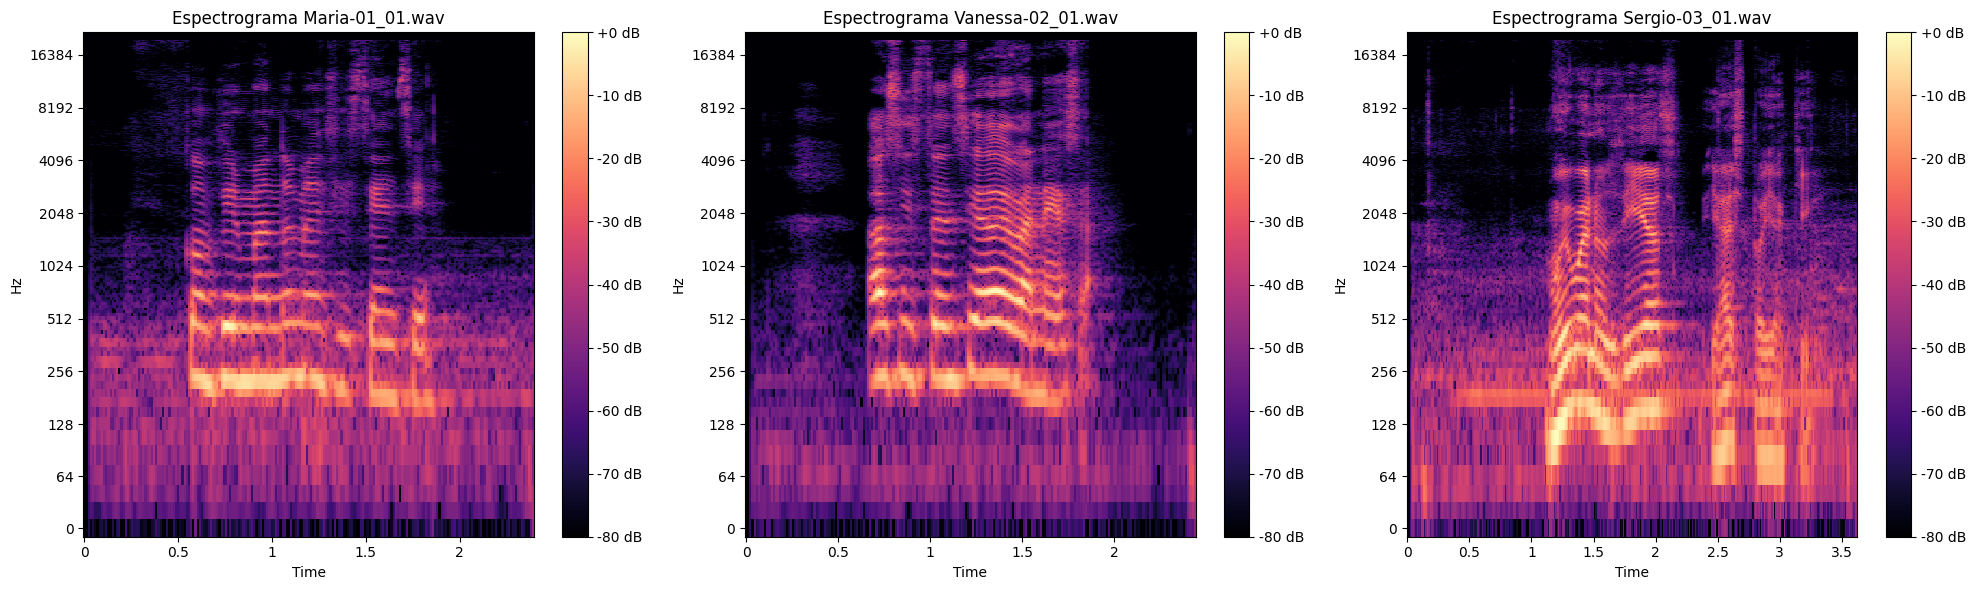

In [ ]:
# Rutas de los archivos de audio
audio_files = [
    '/content/drive/MyDrive/Practica-01_Audio/Maria-01_01.wav',
    '/content/drive/MyDrive/Practica-01_Audio/Vanessa-02_01.wav',
    '/content/drive/MyDrive/Practica-01_Audio/Sergio-03_01.wav'
]

plt.figure(figsize=(20, 6))
# Creación de la figura
for i, audio_file in enumerate(audio_files, 1):
    y, sr = librosa.load(audio_file, sr=None)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.subplot(1, 3, i)  # (1 fila, 3 columnas, índice i)

    librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr)

    plt.title(f'Espectrograma {audio_file.split("/")[-1]}')
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

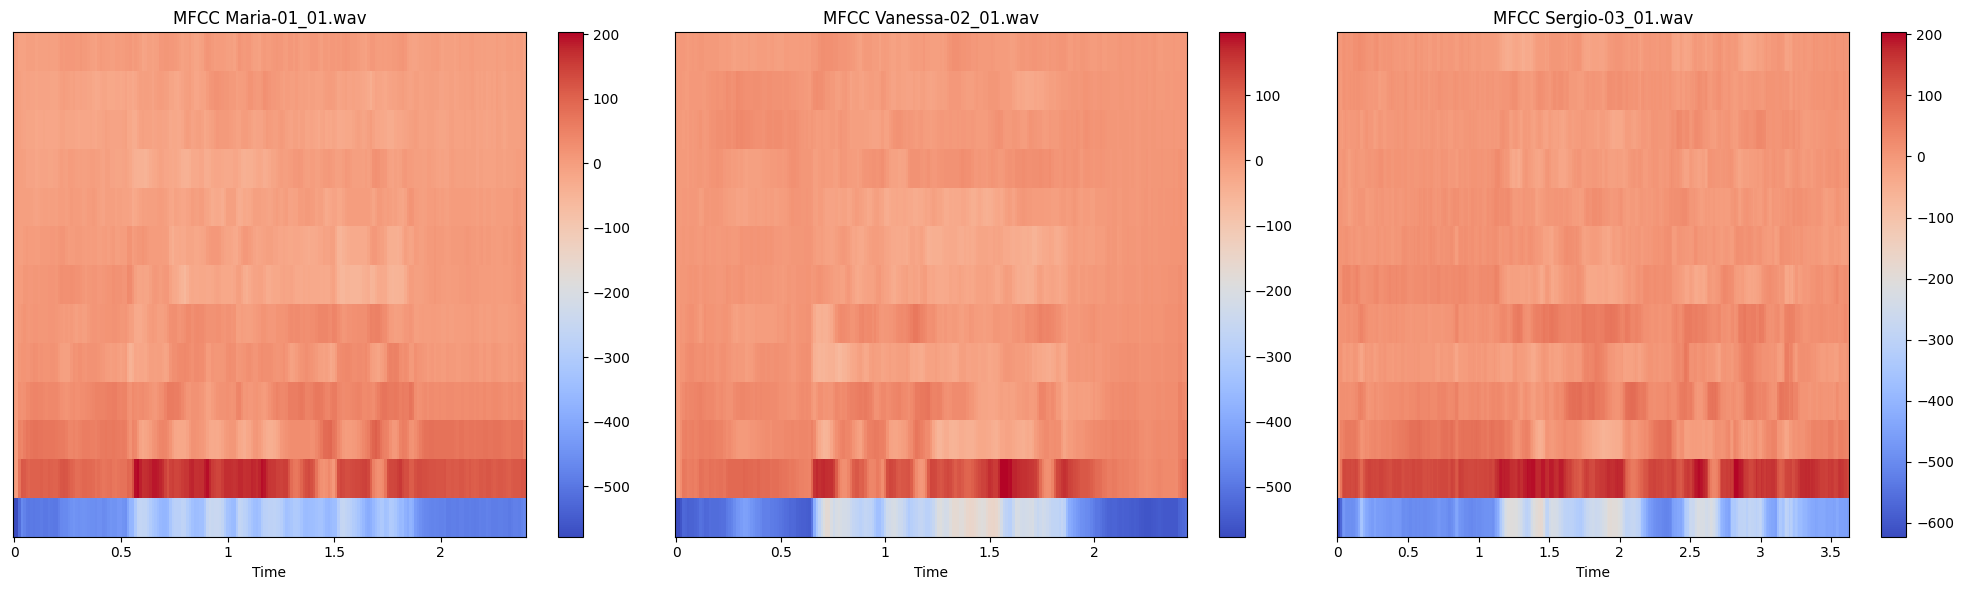

In [ ]:
plt.figure(figsize=(20, 6))

# Iterar sobre los archivos de audio y generar un MFCC para cada uno
for i, audio_file in enumerate(audio_files, 1):
    y, sr = librosa.load(audio_file, sr=None)
    # Extraer MFCC (13 coeficientes)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) # Las primeras 13 características contienen mayor parte de la información revelante para la percepción humnana del sonido.
    plt.subplot(1, 3, i)
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)

    plt.title(f'MFCC {audio_file.split("/")[-1]}')
    plt.colorbar()

plt.tight_layout()
plt.show()

### **Normalización de audios**

En esta sección, los audios fueron normalizados, ajustados para que tuvieran la misma duración y se añadió ruido blanco en los segmentos de silencio para garantizar una reproducción uniforme.

In [15]:
base_path = "/content/drive/MyDrive/CDSI/Notebooks/Practica 1/AUDIO"
null_path = "/content/drive/MyDrive/Nula"

# Obtener lista de archivos de audio
audio_files = []
for path in [base_path, null_path]:
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):  # Solo archivos .wav
                audio_files.append(os.path.join(root, file))

# Carpeta para guardar los audios normalizados en el entorno de ejecución
output_dir = "/content/processed_audios"
os.makedirs(output_dir, exist_ok=True)

# Procesar los audios
for file_path in audio_files:
    # Cargar el audio
    y, sr = librosa.load(file_path, sr=None)

    # Recortar los silencios
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    # Duración a 3 segundos
    target_length = sr * 3
    if len(y_trimmed) < target_length:
        padding = target_length - len(y_trimmed)
        noise = np.random.normal(0, 0.01, padding)  # Ruido blanco
        y_trimmed = np.concatenate((y_trimmed, noise))
    else:
        y_trimmed = y_trimmed[:target_length]

    # Generar nombre del archivo de salida
    file_name = os.path.basename(file_path).replace(".wav", "_normalized.wav")
    output_path = os.path.join(output_dir, file_name)

    # Guardar el archivo procesado
    sf.write(output_path, y_trimmed, sr)

print(f"Audios procesados y guardados en: {output_dir}")

Audios procesados y guardados en: /content/processed_audios


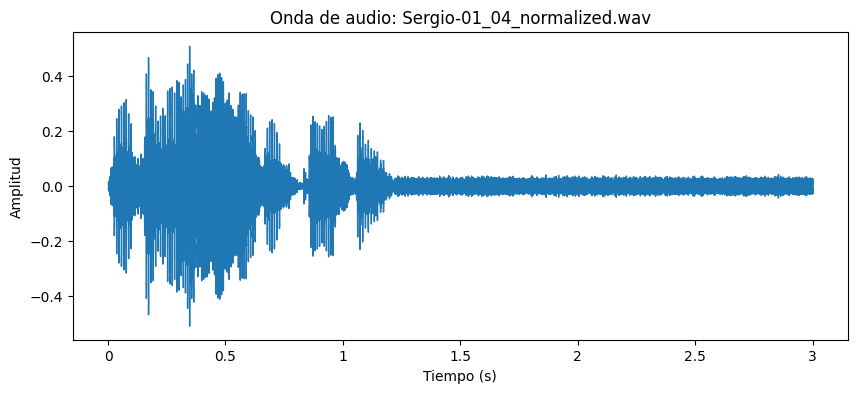

In [ ]:
# Seleccionar un archivo aleatorio de los audios procesados
processed_audio_dir = "/content/processed_audios"
audio_files = [f for f in os.listdir(processed_audio_dir) if f.endswith(".wav")]

if not audio_files:
    print("No hay audios procesados en la carpeta.")
else:
    selected_audio = random.choice(audio_files)  # Seleccionar un audio aleatorio
    audio_path = os.path.join(processed_audio_dir, selected_audio)

    # Cargar el audio
    y, sr = librosa.load(audio_path, sr=None)

    # Graficar la onda de audio
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Onda de audio: {selected_audio}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.show()

### **Aumento de datos**

Definamos algunas funciones para llevar a cabo técnicas de procesamiento de audio con el objetivo de generar audios adicionales.

In [16]:
# Ruta donde se encuentran los audios normalizados
processed_audio_path = "/content/processed_audios"

# Lista de archivos de audio procesados
audio_files = [os.path.join(processed_audio_path, f) for f in os.listdir(processed_audio_path) if f.endswith('.wav')]

# Crear carpeta de salida para los audios aumentados
augmented_folder = "augmented_audio"
os.makedirs(augmented_folder, exist_ok=True)

In [17]:
# Funciones de aumentación
def original(data, rate):
    return data

def noise(data, rate):
    noise_amp = 0.025 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return np.clip(data, -1, 1)

def shift(data, rate):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    data = np.roll(data, shift_range)
    return np.clip(data, -1, 1)

def pitch(data, rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data.astype(np.float32), sr=rate, n_steps=pitch_factor)

def combined(data, rate):
    data = noise(data, rate)
    data = shift(data, rate)
    data = pitch(data, rate)
    return np.clip(data, -1, 1)

In [18]:
augmented_data_list = []

# Función para aplicar aumentaciones y guardar los audios aumentados
def augment_and_save(audio_path, output_folder, augment_func, augment_name, label):
    try:
        # Cargar el audio
        data, sr = librosa.load(audio_path, sr=None)

        # Aplicar la transformación
        augmented_data = augment_func(data, sr)

        # Crear el nombre del archivo aumentado
        base_name = os.path.splitext(os.path.basename(audio_path))[0]
        new_filename = f"{base_name}_{augment_name}.wav"
        new_path = os.path.join(output_folder, new_filename)

        # Guardar el archivo transformado
        sf.write(new_path, augmented_data, sr)
        print(f"Guardado: {new_path}")

        # Agregar la información al DataFrame
        augmented_data_list.append({'labels': label, 'path': new_path, 'augmentation': augment_name})

    except Exception as e:
        print(f"Error procesando {audio_path}: {e}")

# Aplicar aumentaciones a cada archivo normalizado
for file in audio_files:
    label = "Unknown"  # Reemplazar con lógica para extraer la etiqueta, si aplica
    augment_and_save(file, augmented_folder, original, "original", label)
    augment_and_save(file, augmented_folder, noise, "noise", label)
    augment_and_save(file, augmented_folder, shift, "shift", label)
    augment_and_save(file, augmented_folder, pitch, "pitch", label)
    augment_and_save(file, augmented_folder, combined, "combined", label)

# Crear un DataFrame con la información de los audios aumentados
df_augmented = pd.DataFrame(augmented_data_list)
df_augmented.to_csv('df_augmented.csv', index=False)
print("DataFrame de audios aumentados guardado como 'df_augmented.csv'.")

Guardado: augmented_audio/Sergio-03_04_normalized_original.wav
Guardado: augmented_audio/Sergio-03_04_normalized_noise.wav
Guardado: augmented_audio/Sergio-03_04_normalized_shift.wav
Guardado: augmented_audio/Sergio-03_04_normalized_pitch.wav
Guardado: augmented_audio/Sergio-03_04_normalized_combined.wav
Guardado: augmented_audio/Joan-02_03_normalized_original.wav
Guardado: augmented_audio/Joan-02_03_normalized_noise.wav
Guardado: augmented_audio/Joan-02_03_normalized_shift.wav
Guardado: augmented_audio/Joan-02_03_normalized_pitch.wav
Guardado: augmented_audio/Joan-02_03_normalized_combined.wav
Guardado: augmented_audio/Irma-03_03_normalized_original.wav
Guardado: augmented_audio/Irma-03_03_normalized_noise.wav
Guardado: augmented_audio/Irma-03_03_normalized_shift.wav
Guardado: augmented_audio/Irma-03_03_normalized_pitch.wav
Guardado: augmented_audio/Irma-03_03_normalized_combined.wav
Guardado: augmented_audio/AleM-03_5_normalized_original.wav
Guardado: augmented_audio/AleM-03_5_normal

In [19]:
# Ruta para guardar en Google Drive
csv_path = "/content/drive/MyDrive/CDSI/Notebooks/df_augmented.csv"

# Guardar el DataFrame en Drive
df_augmented.to_csv(csv_path, index=False)
print(f"Archivo guardado en: {csv_path}")

Archivo guardado en: /content/drive/MyDrive/CDSI/Notebooks/df_augmented.csv


In [33]:
# DataFrame con rutas de archivos aumentados
df_augmented = pd.DataFrame({"Ruta": [os.path.join(augmented_folder, f) for f in os.listdir(augmented_folder)]})
print(df_augmented.head())

                                                Ruta
0  augmented_audio/Vanessa-02_04_normalized_noise...
1  augmented_audio/ArathDaniela-01_02_normalized_...
2  augmented_audio/Ariana-03_02_normalized_pitch.wav
3            augmented_audio/Vanessa-03_05_pitch.wav
4   augmented_audio/Cielo-02_02_normalized_noise.wav


A continuación, se presentan audios a los que se les aplicaron técnicas de aumento de datos.


 Reproducción de audio: Noise Transformation


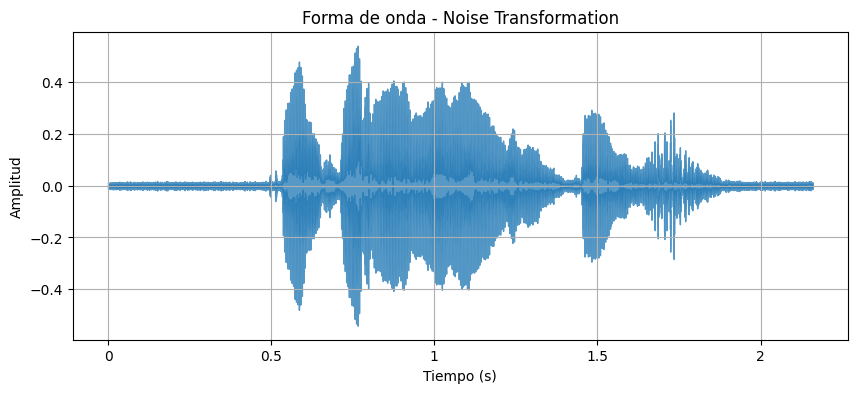


 Reproducción de audio: Shift Transformation


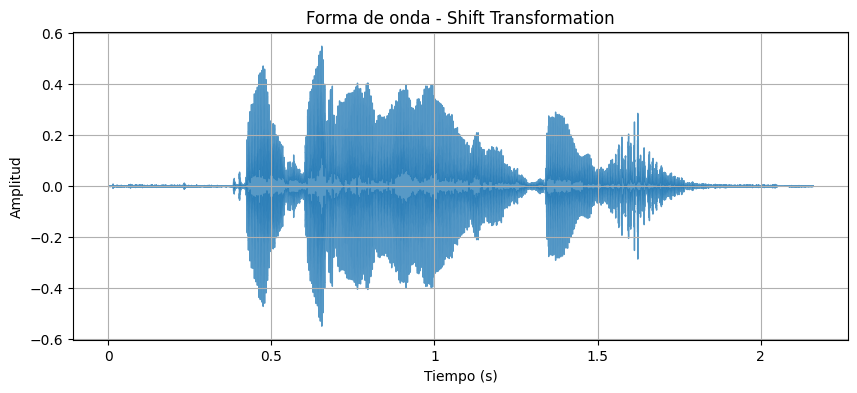


 Reproducción de audio: Pitch Transformation


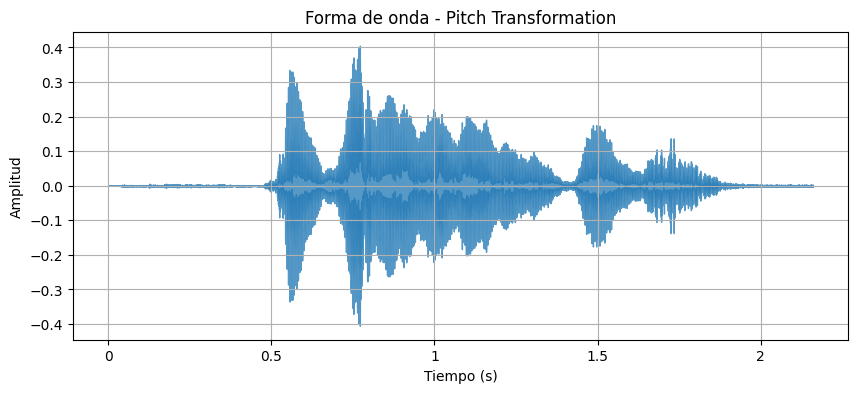


 Reproducción de audio: Combined Transformation


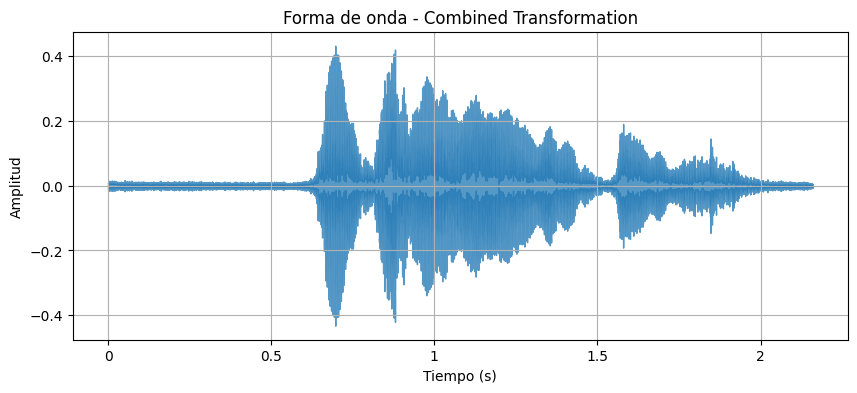

In [ ]:
# Función para cargar y mostrar el audio (según el data aumentation realizado)
def load_and_plot_audio(file_path, title):
    # Cargar el audio
    audio, sr = librosa.load(file_path, sr=None)

    # Reproducción del audio
    print(f"\n Reproducción de audio: {title}")
    display(ipd.Audio(audio, rate=sr))

    # Graficar la onda del audio
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr, alpha=0.75)
    plt.title(f"Forma de onda - {title}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

# Ruta donde se guardaron los audios
augmented_folder = "augmented_audio"

# Audio a reproducir
base_filename = "Vanessa-01_01"

# Lista de transformaciones
augmentations = ["noise", "shift", "pitch", "combined"]

# Reproducir y graficar cada versión del audio
for aug in augmentations:
    file_path = os.path.join(augmented_folder, f"{base_filename}_{aug}.wav")

    if os.path.exists(file_path):
        load_and_plot_audio(file_path, f"{aug.capitalize()} Transformation")
    else:
        print(f"Archivo no encontrado: {file_path}")

In [20]:
display(df_augmented.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        2240 non-null   object
 1   path          2240 non-null   object
 2   augmentation  2240 non-null   object
dtypes: object(3)
memory usage: 52.6+ KB


None

In [21]:
# Ruta para guardar en Google Drive
csv_path = "/content/drive/MyDrive/CDSI/Notebooks/df_augmented.csv"

# Guardar el DataFrame en Drive
df_augmented.to_csv(csv_path, index=False)
print(f"Archivo guardado en: {csv_path}")

Archivo guardado en: /content/drive/MyDrive/CDSI/Notebooks/df_augmented.csv


## **Análisis exploratorio de datos**

,count,class,method
0,25,Mario,01
1,25,BetoM,01
2,25,Ignacio,01
3,25,Daniel,03
4,25,Sergio,03
...,...,...,...
80,25,Maria,02
81,25,Marlon,02
82,25,ArathDaniela,03
83,25,Yoselin Estudillo,01


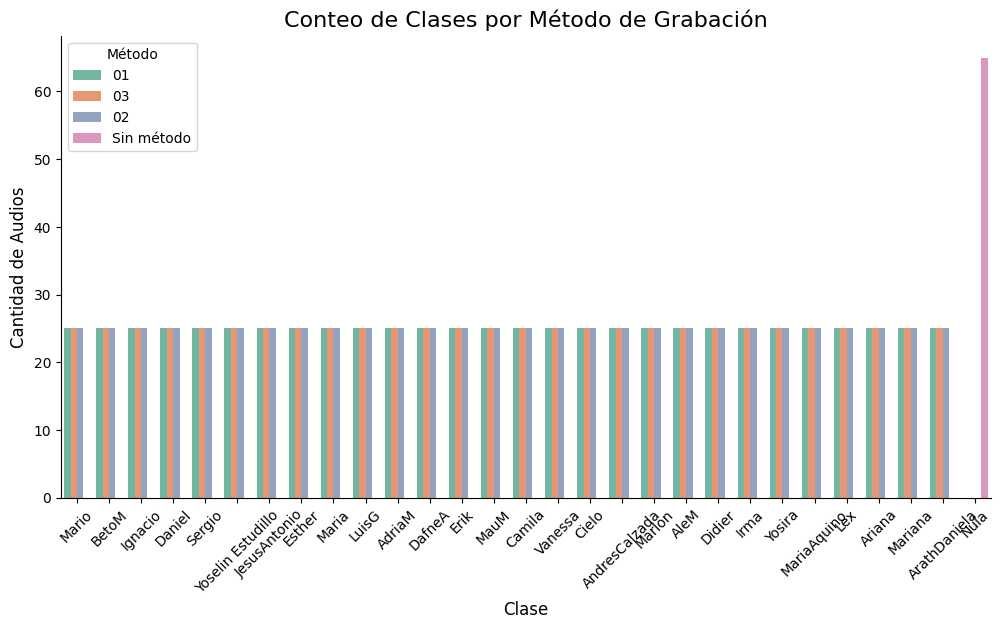

In [ ]:
# Diccionario para contar los archivos por clase y método
archivos_por_clase_metodo = {}
clase_nula_count = 0  # Contador para la Clase Nula

# Recorrer todas las filas del DataFrame `df_augmented`
for index, row in df_augmented.iterrows():
    # Extraer nombre del archivo sin la ruta
    filename = row['Ruta'].split('/')[-1]

    # Verificar si es de Clase Nula
    if filename.startswith("Nula"):
        clase_nula_count += 1
    else:
        # Separar por guión: "Cielo-01_01_pitch.wav" → ["Cielo", "01_01", "pitch.wav"]
        partes = filename.split('-')

        if len(partes) > 1:
            clase = partes[0]
            metodo = partes[1].split('_')[0]

            # Guardar en el diccionario
            clave = (clase, metodo)
            archivos_por_clase_metodo[clave] = archivos_por_clase_metodo.get(clave, 0) + 1

# Convertir a DataFrame
df_clase_metodo = pd.DataFrame.from_dict(archivos_por_clase_metodo, orient='index', columns=['count']).reset_index()
df_clase_metodo[['class', 'method']] = pd.DataFrame(df_clase_metodo['index'].tolist(), index=df_clase_metodo.index)
df_clase_metodo.drop(columns=['index'], inplace=True)

# Agregar la Clase Nula al DataFrame
df_clase_nula = pd.DataFrame({'class': ['Nula'], 'method': ['Sin método'], 'count': [clase_nula_count]})
df_clase_metodo = pd.concat([df_clase_metodo, df_clase_nula], ignore_index=True)

display(df_clase_metodo)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=df_clase_metodo, x='class', y='count', hue='method', palette="Set2")
plt.title('Conteo de Clases por Método de Grabación', size=16)
plt.ylabel('Cantidad de Audios', size=12)
plt.xlabel('Clase', size=12)
plt.xticks(rotation=45)
plt.legend(title='Método')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## **Exctracción de características**

El objetivo de esta sección es extraer características de los audios y convertirlas en un DataFrame.

Las características extraídas serán las siguientes:

* Tasa de cruces por cero (Zero Crossing Rate, ZCR)
* Energía cuadrática media (Root Mean Square, RMS)
* Tono fundamental
* Ritmo y tempo
* Coeficientes MFCC (13 coeficientes)
* Centroide espectral
* Ancho de banda espectral
* Planitud espectral

In [22]:
# Extraer características del audio
def extract_features(audio_file):
    # Cargar la señal de audio
    y, sr = librosa.load(audio_file)

    # Extraer la envolvente de amplitud
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    envelope = np.mean(librosa.amplitude_to_db(onset_env, ref=np.max))

    # Extraer la tasa de cruces por cero (ZCR)
    zcr = librosa.feature.zero_crossing_rate(y=y).mean()

    # Extraer la energía cuadrática media (RMS)
    rms = librosa.feature.rms(y=y).mean()

    # Extraer tono fundamental (pitch)
    pitch, _ = librosa.core.piptrack(y=y, sr=sr)

    # Extraer ritmo y tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    # Extraer características MFCC (13 coeficientes)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)

    # Extraer el centroide espectral
    spectral_centroid = librosa.feature.spectral_centroid(y=y)[0]

    # Extraer el ancho de banda espectral
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y)[0]

    # Extraer la planitud espectral
    spectral_flatness = librosa.feature.spectral_flatness(y=y)[0]

    # Crear un diccionario para almacenar las características
    features_dict = {}

    features_dict["envelope_mean"] = envelope
    features_dict["zcr"] = zcr
    features_dict["rms"] = rms
    features_dict["pitch_mean"] = np.mean(pitch)
    features_dict["tempo"] = tempo

    for i, coef in enumerate(mfcc):
        features_dict[f"mfcc_{i}"] = coef

    for i, val in enumerate(spectral_centroid):
        features_dict[f"spectral_centroid_{i}"] = val

    for i, val in enumerate(spectral_bandwidth):
        features_dict[f"spectral_bandwidth_{i}"] = val

    for i, val in enumerate(spectral_flatness):
        features_dict[f"spectral_flatness_{i}"] = val

    return features_dict

In [24]:
# Lista para almacenar los datos de las características
features_data_list = []

# Iterar sobre cada ruta de audio en el DataFrame (incluyendo clase nula)
for index, row in df_augmented.iterrows():
    # Extraer características del audio
    # Use 'Ruta' instead of 'path' to access the file path
    features = extract_features(row['path'])

    # Extraer la etiqueta y el tipo de aumento del nombre del archivo
    filename = row['path'].split('/')[-1]  # Obtener el nombre del archivo

    if filename.startswith("Nula"):
        label = "Nula"
        augmentation = "original"
    else:
        parts = filename.split('-')
        if len(parts) > 1:
            label = parts[1].split('_')[0]  # Obtener la etiqueta (ej. '01', '02', '03')
            augmentation = parts[1].split('_')[-1].split('.')[0]  # Obtener el tipo de aumento (ej. 'original', 'noise')
        else:
            label = "Desconocido"
            augmentation = "Desconocido"

    # Agregar las características al diccionario de datos
    features_data = {
        "label": label,  # Usar la etiqueta extraída
        "augmentation": augmentation,  # Usar el tipo de aumento extraído
        "path": row['path']
    }
    features_data.update(features)

    # Agregar los datos al listado
    features_data_list.append(features_data)

# DataFrame con los datos de las características
features_df = pd.DataFrame(features_data_list)

# Mostrar el DataFrame con las características extraídas
display(features_df.head())

,label,augmentation,path,envelope_mean,zcr,rms,pitch_mean,tempo,mfcc_0,mfcc_1,...,spectral_flatness_120,spectral_flatness_121,spectral_flatness_122,spectral_flatness_123,spectral_flatness_124,spectral_flatness_125,spectral_flatness_126,spectral_flatness_127,spectral_flatness_128,spectral_flatness_129
0,03,original,augmented_audio/Sergio-03_04_normalized_origin...,-17.767883,0.270380,0.040501,105.707977,[69.83741554054055],-251.161240,53.178268,...,0.393263,0.391184,0.395987,0.405230,0.398359,0.402635,0.375503,0.398226,0.449277,0.510799
1,03,noise,augmented_audio/Sergio-03_04_normalized_noise.wav,-17.014727,0.292988,0.042497,108.401848,[64.599609375],-208.677856,34.596306,...,0.378665,0.402197,0.395487,0.414012,0.388328,0.383684,0.396585,0.373875,0.467704,0.496733
2,03,shift,augmented_audio/Sergio-03_04_normalized_shift.wav,-17.665154,0.269802,0.040509,105.432686,[123.046875],-248.531067,52.845787,...,0.388427,0.401063,0.389271,0.397372,0.234434,0.011167,0.000593,0.000693,0.005109,0.027823
3,03,pitch,augmented_audio/Sergio-03_04_normalized_pitch.wav,-16.857771,0.266034,0.033415,98.487946,[151.99908088235293],-290.972046,51.389687,...,0.319899,0.304498,0.309952,0.338569,0.328771,0.328816,0.316740,0.340521,0.362183,0.385622
4,03,combined,augmented_audio/Sergio-03_04_normalized_combin...,-16.257681,0.283549,0.034067,97.942833,[67.99958881578948],-252.467606,34.033798,...,0.322394,0.288125,0.328229,0.341527,0.342420,0.352467,0.343761,0.325118,0.330957,0.351592


In [10]:
# Ruta para guardar en Google Drive
csv_path = "/content/drive/MyDrive/CDSI/Notebooks/features_df.csv"

# Guardar el DataFrame en Drive
features_df.to_csv(csv_path, index=False)
print(f"Archivo guardado en: {csv_path}")

Archivo guardado en: /content/drive/MyDrive/CDSI/Notebooks/features_df.csv


## **Selección de características**

Debido a la gran cantidad de características obtenidas, se seleccionarán solo las características de MFCC, ya que estas características son especialmente útiles para tareas de clasificación de audio. Los coeficientes MFCC capturan de manera eficiente la información espectral relevante, como las características del timbre y la textura del sonido, lo que las hace altamente representativas en el contexto de la clasificación de voces y otros tipos de sonidos.

In [69]:
def extract_mfcc(audio_file):
    # Cargar la señal de audio
    y, sr = librosa.load(audio_file)

    # Extraer características MFCC (13 coeficientes)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)  # Promedio de cada coeficiente en todos los frames

    # Crear un diccionario para almacenar solo las características MFCC
    features_dict = {}
    for i, coef in enumerate(mfcc):
        features_dict[f"mfcc_{i+1}"] = coef  # Los MFCC suelen empezar desde mfcc_1 hasta mfcc_13

    return features_dict

In [70]:
# Función para extraer solo los MFCC
def extract_mfcc(y, sr, num_mfcc=13):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
    return np.mean(mfccs, axis=1)

# Función principal de extracción de características
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Si el audio es silencioso, devolver None
    if np.max(np.abs(y)) < 0.01:
        return None

    # Extraer solo MFCC
    mfcc_values = extract_mfcc(y, sr, num_mfcc=13)

    # Crear diccionario con solo los MFCC
    features = {f"mfcc_{i+1}": mfcc_values[i] for i in range(13)}

    return features

In [27]:
# Cargar el DataFrame con las rutas de audio
df_augmented = pd.read_csv("/content/drive/MyDrive/CDSI/Notebooks/df_augmented.csv")

# Cargar el DataFrame con las características previamente extraídas
features_df = pd.read_csv("/content/drive/MyDrive/CDSI/Notebooks/features_df.csv")

In [71]:
features_dict = features_df.set_index('path').to_dict(orient='index')

# Lista para almacenar los datos de las características
features_data_list = []


# Iterar sobre cada ruta de audio en el DataFrame
for index, row in df_augmented.iterrows():
    # Extraer características del audio
    features = extract_features(row['path'])

    if features is None:
        continue

    # Extraer la etiqueta y el tipo de aumento del nombre del archivo
    filename = row['path'].split('/')[-1]

    # Verificar si es de Clase Nula
    if filename.startswith("Nula"):
        label = "Nula"
        augmentation = "original"
    else:
        parts = filename.split('-')
        if len(parts) > 1:
            label = parts[1].split('_')[0]  # Obtener la etiqueta (ej. '01', '02', '03')
            augmentation = parts[1].split('_')[-1].split('.')[0]  # Obtener el tipo de aumento (ej. 'original', 'noise')
        else:
            label = "Desconocido"
            augmentation = "Desconocido"

    # Agregar las características al diccionario de datos
    features_data = {
        "label": label,  # Usar la etiqueta extraída
        "augmentation": augmentation,  # Usar el tipo de aumento extraído
        "path": row['path']
    }
    features_data.update(features)

    # Agregar los datos al listado
    features_data_list.append(features_data)

# Crear un nuevo DataFrame con los datos de las características
features_df = pd.DataFrame(features_data_list)

# DataFrame con las características extraídas
display(features_df.head())

,label,augmentation,path,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,03,original,augmented_audio/Sergio-03_04_normalized_origin...,-274.236877,66.673279,-1.605963,15.242921,5.335009,17.959959,-7.160465,7.330199,-1.788935,1.580166,4.738900,4.176456,-5.846540
1,03,noise,augmented_audio/Sergio-03_04_normalized_noise.wav,-216.583160,33.009666,11.067083,7.937468,10.783665,9.243103,1.601852,2.110567,2.011701,0.612721,2.954033,2.265570,-1.893819
2,03,shift,augmented_audio/Sergio-03_04_normalized_shift.wav,-272.607971,65.887070,-1.260860,15.076957,5.710968,17.795813,-7.005052,7.371905,-1.790361,1.602885,4.868165,4.110900,-5.793093
3,03,pitch,augmented_audio/Sergio-03_04_normalized_pitch.wav,-311.375366,64.454102,-0.643144,14.810358,7.663175,16.751474,-7.640153,7.595737,-2.168062,4.038074,4.238790,3.335291,-6.063508
4,03,combined,augmented_audio/Sergio-03_04_normalized_combin...,-260.223175,34.719635,9.888882,9.860184,10.809181,10.102825,0.529426,4.414871,1.753433,2.744306,1.662592,2.555812,-4.224521


In [114]:
# Seleccionar las características y la etiqueta
X = features_df.drop(['label', 'augmentation', 'path'], axis=1)
y = features_df['label']

# Calcular la información mutua
X_new = mutual_info_classif(X, y)

# Crear un DataFrame o Serie con la importancia de las características
feat_imp = pd.Series(X_new, features_df.columns[3:])
# feat_imp = pd.Series(X_new, index=X.columns)

# Mostrar las características con valores de importancia mayores a 0.1
feat_imp_sorted = feat_imp[feat_imp > 0.1].sort_values(ascending=False)
display(feat_imp_sorted)

,0
mfcc_4,0.137591
mfcc_3,0.135759
mfcc_5,0.128925
mfcc_2,0.128430
mfcc_8,0.115478
mfcc_13,0.110842
mfcc_6,0.103557
mfcc_7,0.100334
mfcc_9,0.100159


## **Construcción y evaluación de los modelos**

En esta sección, se llevará a cabo un análisis detallado de las clases "nula" y "1" (método 1), con el objetivo de evaluar su distribución y características

In [72]:
# Función para extraer el método del nombre del archivo
def extract_method(filename):
    parts = filename.split('-')  # Separar por '-'
    if len(parts) > 1:
        method = parts[1].split('_')[0]  # Obtener el método (los dos primeros números después del '-')
        return method
    return None

# Aplicar la función a cada fila del DataFrame
features_df['method'] = features_df['path'].apply(lambda x: extract_method(x.split('/')[-1]))

# Filtrar solo los métodos '00' y '01'
df_filtered_method1 = features_df[features_df['method'].isin(['00', '01'])]

display(df_filtered_method1.head())

,label,augmentation,path,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,method
20,01,original,augmented_audio/BetoM-01_5_normalized_original...,-239.610992,59.468193,-3.546449,16.656288,1.876561,-0.078915,-6.653780,-6.985907,-6.447109,-0.171404,-9.315985,-0.095307,-3.214974,01
21,01,noise,augmented_audio/BetoM-01_5_normalized_noise.wav,-233.654007,52.475498,1.645669,12.717156,4.528964,-1.821950,-5.471280,-7.739769,-5.525043,-1.368300,-7.816480,-1.591453,-1.763498,01
22,01,shift,augmented_audio/BetoM-01_5_normalized_shift.wav,-236.511719,58.105350,-2.702747,16.872103,2.312526,-0.409099,-6.803575,-6.551157,-6.428352,-0.116091,-9.568364,-0.215369,-3.327358,01
23,01,pitch,augmented_audio/BetoM-01_5_normalized_pitch.wav,-274.946442,58.602882,-1.760188,18.512945,1.218338,-2.280328,-10.246464,-7.921514,-7.712564,-0.566383,-9.407681,2.721956,-6.332270,01
24,01,combined,augmented_audio/BetoM-01_5_normalized_combined...,-210.901520,31.004681,7.367709,7.716079,-0.238742,-0.755268,-9.254169,-4.471441,-7.553699,-1.825122,-6.288133,1.613493,-1.277180,01


In [73]:
def extract_name(filename):
    parts = filename.split('-')  # Separar por '-'
    if len(parts) > 0:
        name = parts[0]  # Obtener la primera parte antes del '-'
        return name
    return None

# Aplicar la función a cada fila del DataFrame
df_filtered_method1['name'] = df_filtered_method1['path'].apply(lambda x: extract_name(x.split('/')[-1]))

# Mostrar el DataFrame con la nueva columna 'name'
display(df_filtered_method1[['path', 'name', 'method']].head())

<ipython-input-73-dd570e456fd7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_method1['name'] = df_filtered_method1['path'].apply(lambda x: extract_name(x.split('/')[-1]))


,path,name,method
20,augmented_audio/BetoM-01_5_normalized_original...,BetoM,01
21,augmented_audio/BetoM-01_5_normalized_noise.wav,BetoM,01
22,augmented_audio/BetoM-01_5_normalized_shift.wav,BetoM,01
23,augmented_audio/BetoM-01_5_normalized_pitch.wav,BetoM,01
24,augmented_audio/BetoM-01_5_normalized_combined...,BetoM,01


In [44]:
X = df_filtered_method1.drop(['label', 'augmentation', 'path', 'method', 'name'], axis=1)
y = df_filtered_method1['name']

# Definir el modelo Random Forest
model = RandomForestClassifier(n_estimators=2, random_state=42)

# Configurar validación cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo con validación cruzada
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

# Entrenar el modelo final
model.fit(X, y)

# Mostrar resultados
print(f"Exactitud en validación cruzada: {scores.mean():.4f} ± {scores.std():.4f}")

# Realizar predicciones en el conjunto de entrenamiento
y_pred = model.predict(X)

# Mostrar reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y, y_pred))

Exactitud en validación cruzada: 0.6497 ± 0.0676
Reporte de clasificación:
                   precision    recall  f1-score   support

           AdriaM       0.96      0.96      0.96        25
             AleM       0.76      1.00      0.86        25
    AndresCalzada       0.74      0.92      0.82        25
     ArathDaniela       0.83      0.96      0.89        25
           Ariana       0.72      0.92      0.81        25
            BetoM       0.92      0.92      0.92        25
           Camila       0.96      1.00      0.98        25
            Cielo       0.82      0.92      0.87        25
           DafneA       0.82      0.92      0.87        25
           Daniel       0.77      0.92      0.84        25
           Didier       0.80      0.96      0.87        25
             Erik       0.84      0.84      0.84        25
           Esther       1.00      0.84      0.91        25
          Ignacio       1.00      0.88      0.94        25
             Irma       0.89      1.00 

In [76]:
joblib.dump(model, "/content/drive/MyDrive/CDSI/Notebooks/modelo_random_forest_method1.pkl")
print("Modelo guardado exitosamente en Google Drive.")

Modelo guardado exitosamente en Google Drive.


*Audios mal clasificados*

In [75]:
misclassified_df = df_filtered_method1.copy()
misclassified_df['predicted_name'] = y_pred

# Filtrar los audios mal clasificados
misclassified_df = misclassified_df[misclassified_df['name'] != misclassified_df['predicted_name']]

# Mostrar los audios mal clasificados
print("Audios mal clasificados:")
display(misclassified_df[['path', 'name', 'predicted_name']])

Audios mal clasificados:


,path,name,predicted_name
23,augmented_audio/BetoM-01_5_normalized_pitch.wav,BetoM,AdriaM
66,augmented_audio/AdriaM-01_2_normalized_noise.wav,AdriaM,AleM
94,augmented_audio/LuisG-01_03_normalized_combine...,LuisG,ArathDaniela
101,augmented_audio/Yosira-01_01_normalized_noise.wav,Yosira,Erik
126,augmented_audio/Nula-00_10_normalized_noise.wav,Nula,AleM
...,...,...,...
2213,augmented_audio/MariaAquino-01_04_normalized_o...,MariaAquino,Ariana
2214,augmented_audio/MariaAquino-01_04_normalized_n...,MariaAquino,Ariana
2215,augmented_audio/MariaAquino-01_04_normalized_s...,MariaAquino,Ariana
2216,augmented_audio/MariaAquino-01_04_normalized_p...,MariaAquino,Ariana


El modelo ha alcanzado una exactitud (Accuracy) total de 0.88 (88%), lo que indica que la mayoría de las predicciones realizadas por el modelo son correctas. Sin embargo, se puede observar que aún hay espacio para mejoras en su rendimiento.

La media macro (Macro avg), que es el promedio de las métricas de precisión (precision), recall y F1-score entre todas las clases sin tener en cuenta la cantidad de instancias en cada clase, presenta los siguientes valores: 0.89 para precisión, 0.88 para recall y 0.88 para el F1-score. Esto sugiere que el modelo mantiene un buen rendimiento general equilibrado entre todas las clases.

Por otro lado, la media ponderada (Weighted avg), que toma en cuenta la cantidad de instancias por clase, también muestra buenos resultados: 0.89 de precisión, 0.88 de recall y 0.88 de F1-score. Esto indica que, en general, el modelo tiene un buen desempeño en todas las clases, con un rendimiento sólido en función del número de instancias disponibles en cada clase.

Se clasificaron incorrectamente 93 audios, lo cual representa una pequeña fracción del total de 788 instancias. Esto indica que, aunque el modelo muestra un rendimiento general bastante sólido, todavía existen áreas de oportunidad para optimizar su precisión y reducir la tasa de errores.

***Método 0 y 2***

En esta sección, se llevará a cabo un análisis detallado de las clases "nula" y "2" (método 2), con el objetivo de evaluar su distribución y características

In [77]:
# Función para extraer el método del nombre del archivo
def extract_method(filename):
    parts = filename.split('-')  # Separar por '-'
    if len(parts) > 1:
        method = parts[1].split('_')[0]  # Obtener el método (los dos primeros números después del '-')
        return method
    return None

# Aplicar la función a cada fila del DataFrame
features_df['method'] = features_df['path'].apply(lambda x: extract_method(x.split('/')[-1]))

# Filtrar solo los métodos '00' y '02'
df_filtered_method2 = features_df[features_df['method'].isin(['00', '02'])]

display(df_filtered_method2.head())

,label,augmentation,path,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,method
5,02,original,augmented_audio/Joan-02_03_normalized_original...,-293.475616,42.774590,-8.029490,-0.248081,4.603418,9.123260,-3.403800,-3.215628,-1.780596,-6.984678,-4.287999,-1.716907,0.312625,02
6,02,noise,augmented_audio/Joan-02_03_normalized_noise.wav,-252.491470,17.346447,1.251269,-1.527977,4.914775,5.407393,-0.619717,-3.784007,-3.674444,-4.936900,-4.820301,-1.596396,0.952621,02
7,02,shift,augmented_audio/Joan-02_03_normalized_shift.wav,-292.849915,42.040367,-7.844350,-0.122601,4.484668,9.086618,-3.342165,-3.248522,-1.817942,-6.926462,-4.291698,-1.664765,0.310856,02
8,02,pitch,augmented_audio/Joan-02_03_normalized_pitch.wav,-334.183777,40.384224,-10.695657,0.502597,3.788257,9.403653,-5.758663,-1.611885,-4.360003,-7.524605,-4.702012,-0.476001,-0.241454,02
9,02,combined,augmented_audio/Joan-02_03_normalized_combined...,-315.325806,27.448463,-2.261347,-1.612544,4.573398,6.823954,-3.229699,-2.345047,-3.369866,-4.050655,-5.893282,0.977489,-0.067231,02


In [78]:
def extract_name(filename):
    parts = filename.split('-')  # Separar por '-'
    if len(parts) > 0:
        name = parts[0]  # Obtener la primera parte antes del '-'
        return name
    return None

# Aplicar la función a cada fila del DataFrame
df_filtered_method2['name'] = df_filtered_method2['path'].apply(lambda x: extract_name(x.split('/')[-1]))

# Mostrar el DataFrame con la nueva columna 'name'
display(df_filtered_method2[['path', 'name', 'method']].head())

<ipython-input-78-0d2f2e5ad85b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_method2['name'] = df_filtered_method2['path'].apply(lambda x: extract_name(x.split('/')[-1]))


,path,name,method
5,augmented_audio/Joan-02_03_normalized_original...,Joan,02
6,augmented_audio/Joan-02_03_normalized_noise.wav,Joan,02
7,augmented_audio/Joan-02_03_normalized_shift.wav,Joan,02
8,augmented_audio/Joan-02_03_normalized_pitch.wav,Joan,02
9,augmented_audio/Joan-02_03_normalized_combined...,Joan,02


In [79]:
X = df_filtered_method2.drop(['label', 'augmentation', 'path', 'method', 'name'], axis=1)
y = df_filtered_method2['name']

# Definir el modelo Random Forest
model = RandomForestClassifier(n_estimators=2, random_state=42)

# Configurar validación cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo con validación cruzada
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

# Entrenar el modelo final
model.fit(X, y)

# Mostrar resultados
print(f"Exactitud en validación cruzada: {scores.mean():.4f} ± {scores.std():.4f}")

# Realizar predicciones en el conjunto de entrenamiento
y_pred = model.predict(X)

# Mostrar reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y, y_pred))

Exactitud en validación cruzada: 0.6777 ± 0.0307
Reporte de clasificación:
                   precision    recall  f1-score   support

           AdriaM       0.93      1.00      0.96        25
             AleM       0.85      0.92      0.88        25
    AndresCalzada       0.88      0.92      0.90        25
     ArathDaniela       0.72      0.92      0.81        25
           Ariana       0.91      0.80      0.85        25
            BetoM       0.73      0.96      0.83        25
           Camila       0.96      1.00      0.98        25
            Cielo       0.81      0.88      0.85        25
           DafneA       0.78      0.84      0.81        25
           Daniel       0.96      0.96      0.96        25
           Didier       0.88      0.92      0.90        25
             Erik       0.96      1.00      0.98        25
           Esther       0.96      1.00      0.98        25
          Ignacio       0.80      0.96      0.87        25
             Irma       0.96      0.92 

In [81]:
joblib.dump(model, "/content/drive/MyDrive/CDSI/Notebooks/modelo_random_forest_method2.pkl")
print("Modelo guardado exitosamente en Google Drive.")

Modelo guardado exitosamente en Google Drive.


*Audios mal clasificados*

In [80]:
misclassified_df = df_filtered_method2.copy()
misclassified_df['predicted_name'] = y_pred

# Filtrar los audios mal clasificados
misclassified_df = misclassified_df[misclassified_df['name'] != misclassified_df['predicted_name']]

# Mostrar los audios mal clasificados
print("Audios mal clasificados:")
display(misclassified_df[['path', 'name', 'predicted_name']])

Audios mal clasificados:


,path,name,predicted_name
8,augmented_audio/Joan-02_03_normalized_pitch.wav,Joan,Didier
34,augmented_audio/Marlon-02_02_normalized_combin...,Marlon,Ignacio
36,augmented_audio/Sergio-02_01_normalized_noise.wav,Sergio,Mario
38,augmented_audio/Sergio-02_01_normalized_pitch.wav,Sergio,Maria
71,augmented_audio/Marlon-02_01_normalized_noise.wav,Marlon,JesusAntonio
...,...,...,...
2077,augmented_audio/AndresCalzada-02_04_normalized...,AndresCalzada,Mariana
2134,augmented_audio/Yoselin Estudillo-02_05_normal...,Yoselin Estudillo,Maria
2158,augmented_audio/Mariana-02_02_normalized_origi...,Mariana,DafneA
2160,augmented_audio/Mariana-02_02_normalized_shift...,Mariana,DafneA


El modelo alcanzó una exactitud del 90%, lo que significa que el 90% de los audios fueron clasificados correctamente. Este resultado representa una mejora con respecto a evaluaciones anteriores, reflejando un avance en la precisión del modelo.

En términos de métricas generales, el macro promedio de precisión, recall y F1-score fue de 0.91, 0.90 y 0.90, respectivamente. Estas métricas indican que el rendimiento del modelo es bastante equilibrado entre las distintas clases. Por otro lado, el promedio ponderado, que tiene en cuenta la cantidad de instancias por clase, presentó valores similares (0.91, 0.90 y 0.90), lo que confirma la estabilidad del modelo en la clasificación.

A pesar del buen desempeño, se identificaron 76 audios mal clasificados de un total de 788. Aunque la cantidad de errores es relativamente baja, algunas clases presentaron mayor dificultad en la clasificación.

***Metodo 0 y 3***

En esta sección, se llevará a cabo un análisis detallado de las clases "nula" y "3" (método 3), con el objetivo de evaluar su distribución y características

In [45]:
# Función para extraer el método del nombre del archivo
def extract_method(filename):
    parts = filename.split('-')  # Separar por '-'
    if len(parts) > 1:
        method = parts[1].split('_')[0]  # Obtener el método (los dos primeros números después del '-')
        return method
    return None

# Aplicar la función a cada fila del DataFrame
features_df['method'] = features_df['path'].apply(lambda x: extract_method(x.split('/')[-1]))

# Filtrar solo los métodos '00' y '03'
df_filtered_method3 = features_df[features_df['method'].isin(['00', '03'])]

display(df_filtered_method3.head())

,label,augmentation,path,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,method
0,03,original,augmented_audio/Sergio-03_04_normalized_origin...,-274.236877,66.673279,-1.605963,15.242921,5.335009,17.959959,-7.160465,7.330199,-1.788935,1.580166,4.738900,4.176456,-5.846540,03
1,03,noise,augmented_audio/Sergio-03_04_normalized_noise.wav,-216.583160,33.009666,11.067083,7.937468,10.783665,9.243103,1.601852,2.110567,2.011701,0.612721,2.954033,2.265570,-1.893819,03
2,03,shift,augmented_audio/Sergio-03_04_normalized_shift.wav,-272.607971,65.887070,-1.260860,15.076957,5.710968,17.795813,-7.005052,7.371905,-1.790361,1.602885,4.868165,4.110900,-5.793093,03
3,03,pitch,augmented_audio/Sergio-03_04_normalized_pitch.wav,-311.375366,64.454102,-0.643144,14.810358,7.663175,16.751474,-7.640153,7.595737,-2.168062,4.038074,4.238790,3.335291,-6.063508,03
4,03,combined,augmented_audio/Sergio-03_04_normalized_combin...,-260.223175,34.719635,9.888882,9.860184,10.809181,10.102825,0.529426,4.414871,1.753433,2.744306,1.662592,2.555812,-4.224521,03


In [48]:
def extract_name(filename):
    parts = filename.split('-')  # Separar por '-'
    if len(parts) > 0:
        name = parts[0]  # Obtener la primera parte antes del '-'
        return name
    return None

# Aplicar la función a cada fila del DataFrame
df_filtered_method3['name'] = df_filtered_method3['path'].apply(lambda x: extract_name(x.split('/')[-1]))

# Mostrar el DataFrame con la nueva columna 'name'
display(df_filtered_method3[['path', 'name', 'method']].head())

<ipython-input-48-808794a25fa4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_method3['name'] = df_filtered_method3['path'].apply(lambda x: extract_name(x.split('/')[-1]))


,path,name,method
0,augmented_audio/Sergio-03_04_normalized_origin...,Sergio,03
1,augmented_audio/Sergio-03_04_normalized_noise.wav,Sergio,03
2,augmented_audio/Sergio-03_04_normalized_shift.wav,Sergio,03
3,augmented_audio/Sergio-03_04_normalized_pitch.wav,Sergio,03
4,augmented_audio/Sergio-03_04_normalized_combin...,Sergio,03


In [49]:
X = df_filtered_method3.drop(['label', 'augmentation', 'path', 'method', 'name'], axis=1)
y = df_filtered_method3['name']

# Definir el modelo Random Forest
model = RandomForestClassifier(n_estimators=2, random_state=42)

# Configurar validación cruzada estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo con validación cruzada
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

# Entrenar el modelo final
model.fit(X, y)

# Mostrar resultados
print(f"Exactitud en validación cruzada: {scores.mean():.4f} ± {scores.std():.4f}")

# Realizar predicciones en el conjunto de entrenamiento
y_pred = model.predict(X)

# Mostrar reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y, y_pred))

Exactitud en validación cruzada: 0.5647 ± 0.0298
Reporte de clasificación:
                   precision    recall  f1-score   support

           AdriaM       0.89      1.00      0.94        25
             AleM       1.00      1.00      1.00        25
    AndresCalzada       0.65      0.96      0.77        25
     ArathDaniela       0.68      1.00      0.81        25
           Ariana       0.76      0.88      0.81        25
            BetoM       0.76      0.76      0.76        25
           Camila       0.80      0.96      0.87        25
            Cielo       0.73      0.88      0.80        25
           DafneA       0.64      0.92      0.75        25
           Daniel       0.67      0.80      0.73        25
           Didier       0.96      0.96      0.96        25
             Erik       0.77      0.96      0.86        25
           Esther       0.69      0.88      0.77        25
          Ignacio       0.86      0.96      0.91        25
             Irma       0.94      0.64 

In [50]:
joblib.dump(model, "/content/drive/MyDrive/CDSI/Notebooks/modelo_random_forest_method3.pkl")
print("Modelo guardado exitosamente en Google Drive.")

Modelo guardado exitosamente en Google Drive.


Audios mal clasificados

In [53]:
misclassified_df = df_filtered_method3.copy()
misclassified_df['predicted_name'] = y_pred

# Filtrar los audios mal clasificados
misclassified_df = misclassified_df[misclassified_df['name'] != misclassified_df['predicted_name']]

# Mostrar los audios mal clasificados
print("Audios mal clasificados:")
display(misclassified_df[['path', 'name', 'predicted_name']])

Audios mal clasificados:


,path,name,predicted_name
3,augmented_audio/Sergio-03_04_normalized_pitch.wav,Sergio,BetoM
41,augmented_audio/Vanessa-03_01_normalized_noise...,Vanessa,MauM
46,augmented_audio/Sergio-03_03_normalized_noise.wav,Sergio,Marlon
51,augmented_audio/Maria-03_01_normalized_noise.wav,Maria,ArathDaniela
54,augmented_audio/Maria-03_01_normalized_combine...,Maria,MariaAquino
...,...,...,...
2063,augmented_audio/Mariana-03_05_normalized_origi...,Mariana,Erik
2065,augmented_audio/Mariana-03_05_normalized_shift...,Mariana,Erik
2066,augmented_audio/Mariana-03_05_normalized_pitch...,Mariana,ArathDaniela
2129,augmented_audio/LuisG-03_03_normalized_noise.wav,LuisG,Ignacio


El modelo presenta un rendimiento aceptable con una exactitud del 85%, pero la tasa de error de 120 audios mal clasificados indica que aún hay espacio para mejoras. Si bien algunas clases son identificadas con gran precisión, otras presentan dificultades que podrían corregirse con técnicas de aumento de datos y optimización del modelo.

## **Conclusión**

Para la elaboración de este notebook, se llevó a cabo la captura de datos de audio mediante la grabación de personas simulando la entrada a un edificio. El objetivo de este procedimiento fue reemplazar los métodos tradicionales de registro, como el llenado manual de listas o la lectura de códigos QR.

Posteriormente, los audios fueron procesados y se extrajeron diversas características acústicas. Durante este preprocesamiento, se aplicaron técnicas de mejora y transformación, como la adición de ruido, el cambio de tono y el alargamiento del audio, entre otras.

Las características extraídas de cada audio incluyen:

* Características temporales: envolvente de amplitud, tasa de cruces por cero (ZCR) y energía cuadrática media (RMS).
* Características espectrales: tono fundamental, ritmo y tempo.
* Coeficientes cepstrales: 13 coeficientes MFCC.
* Características espectrales avanzadas: centroide espectral, ancho de banda espectral y planitud espectral.
* Para la selección de características, se optó por utilizar los MFCC, ya que capturan de manera eficiente la información espectral relevante para la clasificación de los audios.

El modelo empleado para la clasificación fue Random Forest, el cual se evaluó mediante una validación cruzada estratificada de 5 folds para garantizar un análisis robusto del desempeño.

Además, se realizó un análisis detallado de las instancias mal clasificadas por el modelo en cada método evaluado. Finalmente, se desarrolló un notebook complementario que permite la evaluación en tiempo real, incluyendo la grabación de audio y la predicción del hablante con base en un conjunto de datos preexistente.